# Expense Manager

## Importing Libraries 

In [1]:
import pygsheets
import pydrive
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import regex as re
import time
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

In [2]:
gc = pygsheets.authorize(service_file='sheets-b4a2e84afc87.json')
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1g7MaNS74UR86VXFnaaIEDrBskKfJ-2tBx_100zAK_oo/edit#gid=0')

## Setting Constants

In [3]:
month_dict = {'01':'January','02':'February','03':'March','04':'April','05':'May','06':'June','07':'July','08':'August','09':'September','10':'October','11':'November','12':'December',}

## Data Processing

In [4]:
data = sh[0].get_as_df()

In [5]:
#Converting into Integer
numeric_columns = ['No. of Shares','Quantity','Total Amount','Total Amount/Person']
for column_name in numeric_columns:
    data[column_name] = data[column_name].astype(float)

In [6]:
def days_gross_values(data_in):
    days = data_in['Date'].nunique()
    gross_expense = data_in['Total Amount'].sum()
    gross_per_person = data_in['Total Amount/Person'].sum()
    return days,gross_expense,gross_per_person

In [7]:
def update_month_set():
    month_set = set()
    for date in data['Date']:
        month_set.add('{} {}'.format(date.split('-')[1],date.split('-')[2]))
    return month_set

In [8]:
def init_month_data_dict():
    month_data_dict = {}
    for month in month_set:
        month_data_dict[month] = pd.DataFrame(columns=['Date','Item','No. of Shares','Quantity','Quantity/Person','Total Amount','Total Aomunt/Person','Comments'])
    return month_data_dict

In [9]:
def update_month_data_dict():
    for i in data.iloc:
        month_data_dict['{} {}'.format(i['Date'].split('-')[1],i['Date'].split('-')[2])] = month_data_dict['{} {}'.format(i['Date'].split('-')[1],i['Date'].split('-')[2])].append(pd.DataFrame(i).T)
    return month_data_dict

In [10]:
def update_latest_month():
    y = 0
    m = 0
    for month in month_set:
        if int(month.split(' ')[1])>int(y):
            y = month.split(' ')[1]
    del(month)
    for month in month_set:
        if y in month:
            if int(month.split(' ')[0])>int(m):
                m = month.split(' ')[0]
    return '{} {}'.format(m,y)

In [11]:
def create_sheet():
    for month in month_set:
        try:
            sh.add_worksheet('{} {}'.format(month_dict[month.split(' ')[0]],month.split(' ')[1]))
        except:
            pass

In [12]:
month_set = update_month_set()

In [13]:
month_data_dict = init_month_data_dict()

In [14]:
month_data_dict = update_month_data_dict()

In [39]:
latest_month = update_latest_month()

In [16]:
create_sheet()

## Data Analysis

In [19]:
def day_analysis(data_in,days):
    data_per_day = pd.DataFrame(columns=['Date','Total Amount','Total Amount/Person'])
    for date in data_in['Date'].unique():
        daily_data = data_in[data_in['Date'] == date]
        total_amount = daily_data['Total Amount'].sum()
        total_per_person = daily_data['Total Amount/Person'].sum()
        data_per_day = data_per_day.append({'Date': date, 'Total Amount': total_amount,'Total Amount/Person': total_per_person},ignore_index=True)
    return data_per_day

In [20]:
def item_analysis(data_in,days):
    item_data = pd.DataFrame(columns=['Item','Frequency','Frequency/Days','Quantity','Quantity/Person','Quantity/Days','Total Amount','Total Amount/Person','Per Person/Days'])
    for items in data_in.Item.unique():
        items_data = data_in[data_in['Item'] == items]
        frequency = items_data.shape[0]
        quantity = items_data['Quantity'].sum()
        quantity_per_person = items_data['Quantity/Person'].sum()
        per_person_total = items_data['Total Amount/Person'].sum()
        total_amount = items_data['Total Amount'].sum()
        item_data = item_data.append({'Item':items,'Frequency': frequency,'Frequency/Days': frequency/days,'Quantity': quantity,'Quantity/Person': quantity_per_person,'Quantity/Days': quantity/days,'Total Amount': total_amount,'Total Amount/Person': per_person_total,'Per Person/Days': per_person_total/days},ignore_index=True)
    return item_data

In [21]:
def data_update(data_in,sheet):
    days,gross_expense,gross_per_person = days_gross_values(data_in)
    data_per_day = day_analysis(data_in,days)
    item_data = item_analysis(data_in,days)
    
    sheet.set_dataframe(data_per_day.round(2),'K2')
    sheet.set_dataframe(item_data.sort_values(by=['Total Amount']).round(2),'A2')
    sheet.cell('O3').set_value('Days')
    sheet.cell('O4').set_value('Gross expense')
    sheet.cell('O5').set_value('Gross per person expense')
    sheet.cell('O6').set_value('GPP/Days')
    sheet.cell('P3').set_value(days)
    sheet.cell('P4').set_value(round(gross_expense,2))
    sheet.cell('P5').set_value(round(gross_per_person,2))
    sheet.cell('P6').set_value(round(gross_per_person/days,2))

In [22]:
def monthly_update():
    for i in month_set:
        data_in = month_data_dict[i]
        sheet = sh.worksheet_by_title('{} {}'.format(month_dict[i.split(' ')[0]],i.split(' ')[1]))
        data_update(data_in,sheet)

In [23]:
def latest_update():
    data_in = month_data_dict[latest_month]
    sheet = sh.worksheet_by_title('{} {}'.format(month_dict[latest_month.split(' ')[0]],latest_month.split(' ')[1]))
    data_update(data_in,sheet)

In [24]:
latest_update()

In [21]:
data_update(data,sh.worksheet_by_title('Gross Total'))

In [22]:
monthly_update()

## Plotting

In [27]:
def gen_perday_values(df_column,if_int):
    try:
        holder_list = list()
        for value in df_column:
            if value != None:
                if if_int:
                    holder_list.append(int(value))
                else:
                    holder_list.append(value)
        holder_list.reverse()
        return holder_list
    except:
        pass

In [28]:
def gen_moving_avg(list_values):
    holder_list = list()
    n = 1
    total = 0
    for value in list_values:
        total += value
        avg = total/n
        holder_list.append(avg)
        n += 1
    return holder_list

In [29]:
def TPD_plot(TPD,TPD_avg,dates,filename,):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    values = TPD
    labels = dates

    plt.plot(labels, values,color='orange')
    plt.plot(TPD_avg,color='r')

    for i, v in enumerate(values):
        ax.text(i, v+15, "%d" %v, ha="center",fontsize=13)

    for i, v in enumerate(TPD_avg):
        ax.text(i, v+15, "%d" %v, ha="center",fontsize=13)

    plt.title('{} Total Per Day Expense'.format(filename),pad=10,fontsize=20)
    plt.xlabel('Dates',fontsize=15)
    plt.ylabel('Amount',fontsize=15)
    plt.xticks(rotation=45,fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(True)
    daily_line = matplotlib.patches.Patch(color='orange', label='Daily Values')
    avg_line = matplotlib.patches.Patch(color='red', label='Moving Average')
    plt.legend(handles=[daily_line,avg_line],fontsize=13,loc=2)
    plt.savefig('./plots/{}_TPD.jpg'.format(filename))
#     plt.show()

In [30]:
def TPP_plot(TPP,TPP_avg,dates,filename):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    values = TPP
    labels = dates

    plt.plot(labels, values,color='orange')
    plt.plot(TPP_avg,color='red')

    for i, v in enumerate(values):
        ax.text(i, v+15, "%d" %v, ha="center",fontsize=13)

    for i, v in enumerate(TPP_avg):
        ax.text(i, v+15, "%d" %v, ha="center",fontsize=13)

    plt.title('{} Total Per Person Expense'.format(filename),pad=10,fontsize=20)
    daily_line = matplotlib.patches.Patch(color='orange', label='Daily Values')
    avg_line = matplotlib.patches.Patch(color='red', label='Moving Average')
    plt.legend(handles=[daily_line,avg_line],fontsize=13,loc=2)
    plt.grid(True)
    plt.xlabel('Dates',fontsize=15)
    plt.ylabel('Amount',fontsize=15)
    plt.xticks(rotation=45,fontsize=13)
    plt.yticks(fontsize=13)
    plt.savefig('./plots/{}_TPP.jpg'.format(filename))
#     plt.show()

In [31]:
def pie_plot(top_10_df,filename):
    top_10_df.sort_values(by=['Total Amount']).iloc[-10:].set_index(top_10_df.sort_values(by=['Total Amount']).iloc[-10:]['Item']).plot.pie(y='Total Amount',legend=None,autopct='%1.0f%%',pctdistance=0.9,fontsize=15)
    plt.title('{} Top 10 Items'.format(filename),fontsize=20)
    plt.savefig('./plots/{}_top_10_pie.jpg'.format(filename))
#     plt.show()

In [32]:
def plot(sheet,data_in,filename):
            days,gross_expense,gross_per_person = days_gross_values(data_in)
            data_per_day = day_analysis(data_in,days)
            item_data = item_analysis(data_in,days)

            data_processed = sheet.get_as_df()
            dates = gen_perday_values(data_per_day['Date'],0)
            TPD = gen_perday_values(data_per_day['Total Amount'],1)
            TPP = gen_perday_values(data_per_day['Total Amount/Person'],0)
            TPD_avg = gen_moving_avg(TPD)
            TPP_avg = gen_moving_avg(TPP)
            Others_df = pd.DataFrame(item_data.sort_values(by=['Total Amount']).iloc[0:-10,:].sum()).T
            Others_df['Item'][0] = 'Others'
            top_10_df = item_data.sort_values(by=['Total Amount']).iloc[-10:]
            top_10_df = top_10_df.append(Others_df)

            filename = re.sub(' ','_',filename)

            TPD_plot(TPD,TPD_avg,dates,filename)
            TPP_plot(TPP,TPP_avg,dates,filename)
            pie_plot(top_10_df,filename)

In [33]:
def plot_monthly():
    for i in month_set:
        sheet = sh.worksheet_by_title('{} {}'.format(month_dict[i.split(' ')[0]],i.split(' ')[1]))
        data_in = month_data_dict[i]
        plot(sheet,data_in,i)

In [34]:
def plot_total():
    sheet = sh[1]
    data_in = data
    plot(sheet,data_in,'total')

In [ ]:
plot_monthly()

In [ ]:
plot_total()

In [37]:
def plot_latest():
    sheet = sh.worksheet_by_title('{} {}'.format(month_dict[latest_month.split(' ')[0]],latest_month.split(' ')[1]))
    data_in = month_data_dict[latest_month]
    plot(sheet,data_in,latest_month)

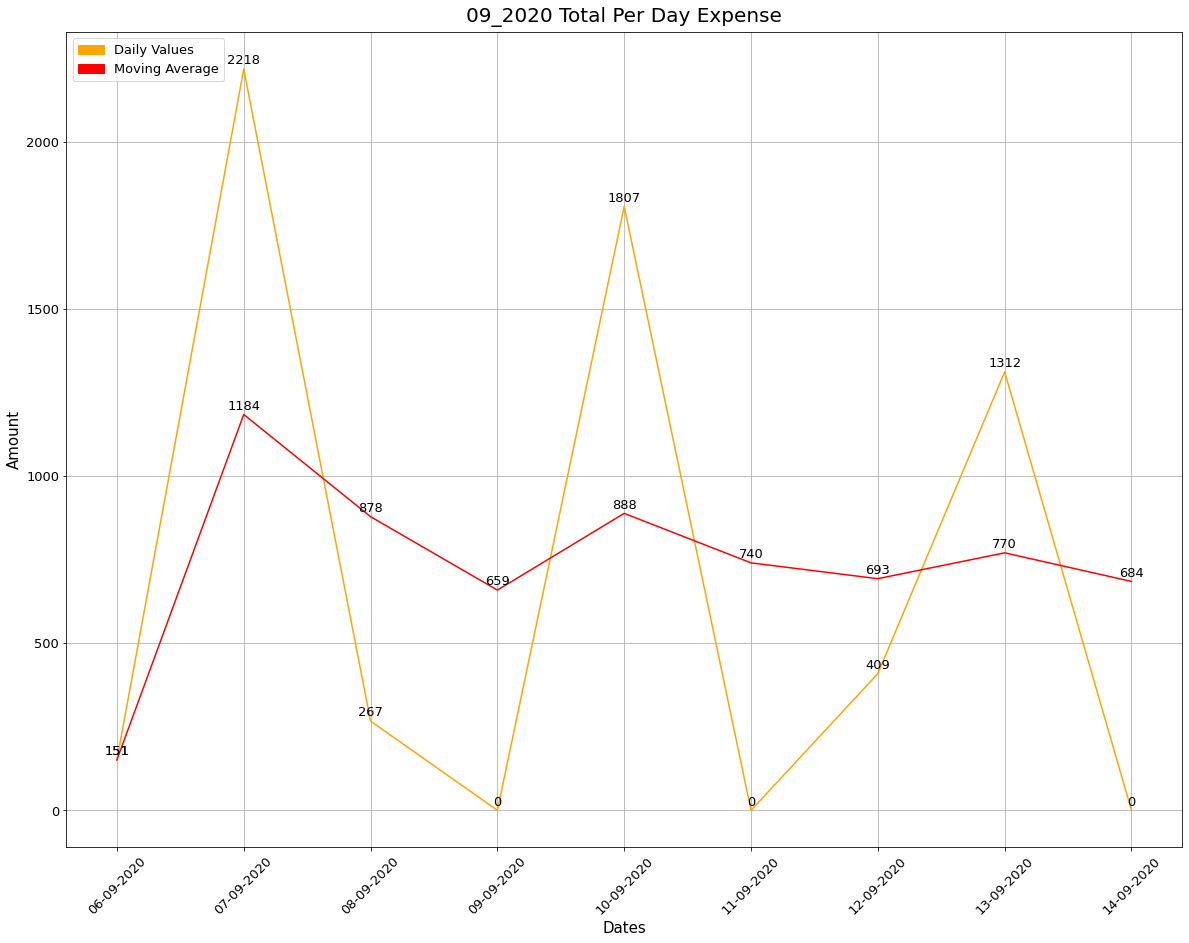

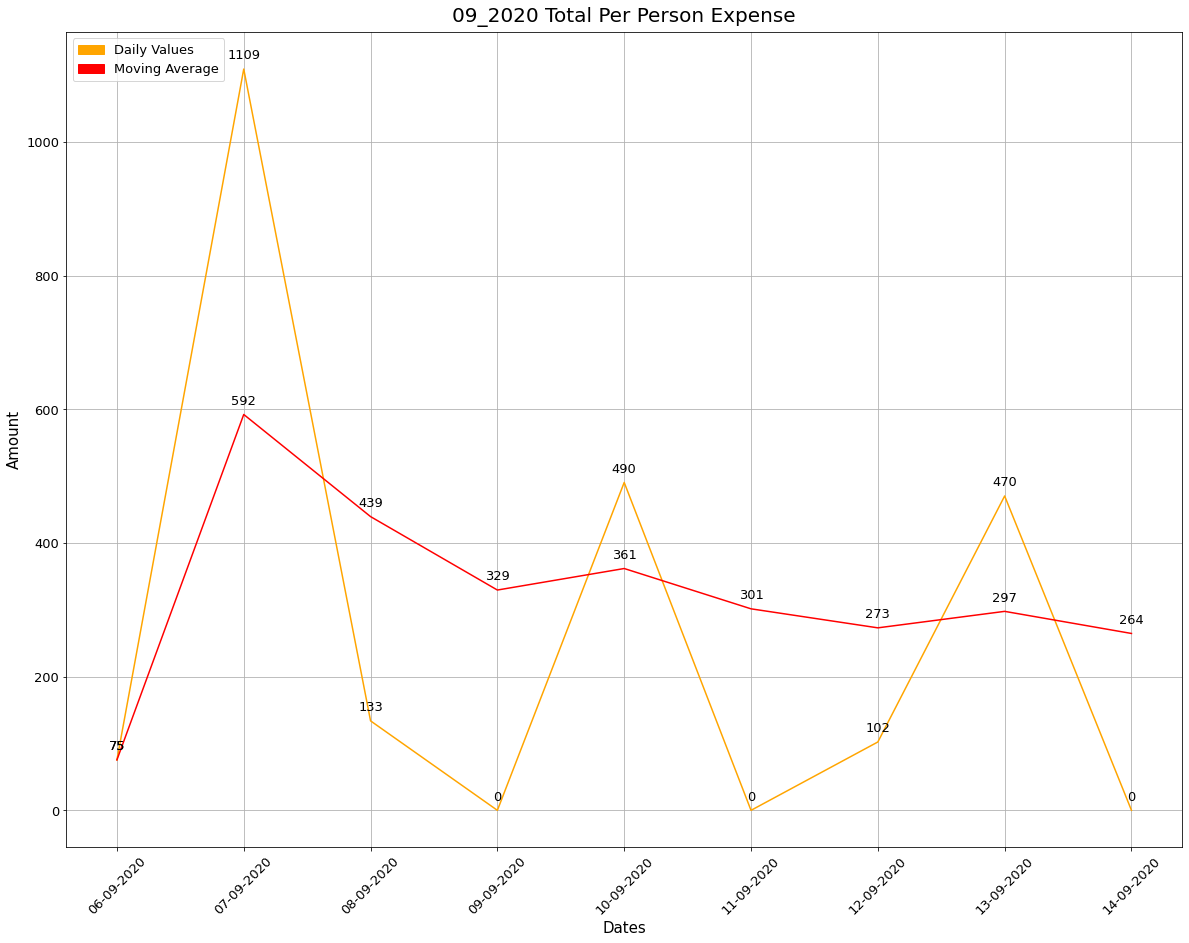

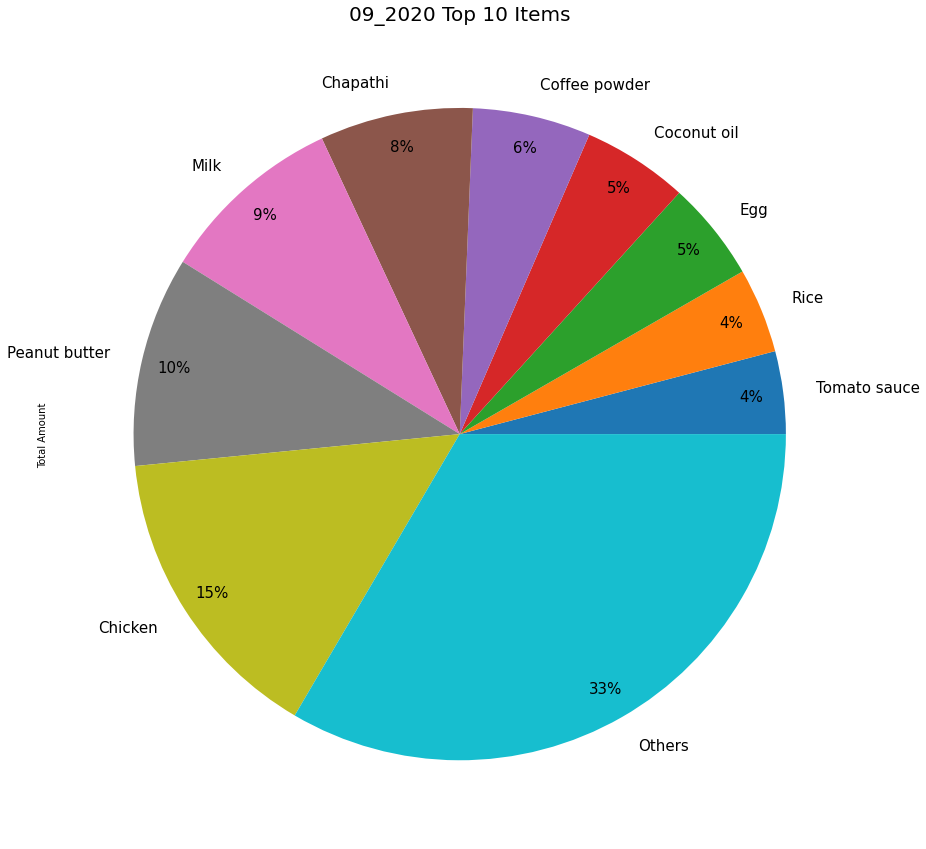

In [38]:
plot_latest()